In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import sys, os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pydicom
from pydicom.data import get_testdata_files

In [5]:
root = "/content/drive/MyDrive/Colab Notebooks/Processamento de Imagens/"

In [6]:
# --- Loading images ---
filenames = []
train_imgs = []
test_imgs = []
for filename in os.listdir(root+"train_images"):
    filenames.append( filename.replace("-c.dcm", "").replace(".dmc","") )
    train_imgs.append( pydicom.dcmread(root+"train_images/"+filename).pixel_array )
for filename in os.listdir(root+"test_images"):
    test_imgs.append( pydicom.dcmread(root+"test_images/"+filename).pixel_array )
train_imgs = np.array(train_imgs)
test_imgs = np.array(test_imgs)

# --- Get train image labels ---
train_labels = pd.read_csv(root+"train.csv")
keys = list(train_labels.iloc[:,0])
values = np.array([name.split()[0] for name in list(train_labels.iloc[:,1])]).astype(int)
file_to_class = dict(zip(keys, values))
labels = np.array([file_to_class.get(filename) for filename in filenames])

bodyparts = {0:'Abdomen', 1:'Ankle', 2:'Cervical Spine', 3:'Chest', 4:'Clavicles', 5:'Elbow',
             6:'Feet' ,7 : 'Finger' ,8 : 'Forearm' ,9 : 'Hand' ,10 : 'Hip' ,11 : 'Knee',
             12: 'Lower Leg', 13 : 'Lumbar Spine' ,14 : 'Others' ,15 :'Pelvis',16 :'Shoulder',
             17:'Sinus', 18:'Skull', 19 : 'Thigh' ,20 :'Thoracic Spine',21: 'Wrist'}
label_names = np.array([bodyparts[label] for label in labels])

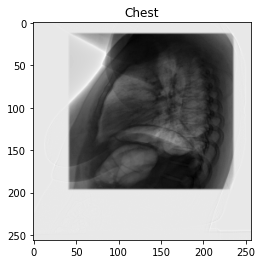

In [7]:
j = 3
plt.imshow(train_imgs[j], cmap = "gray")
plt.title(label_names[j])
plt.show()

In [8]:
def normalize(img, a = 0, b = 255):
    img = img.astype(float)
    
    imax = np.max(img)
    imin = np.min(img)
    
    if(imin == imax):
        np.ones(shape = img.shape) * a
    
    img = (img - imin) / (imax - imin) * b
    return img

def sliced_gray(I, A, B, L, method = 0, plot = True):
    '''
        method = 0 : Binário
        method = 1 : Identity
        method = 2 : Negative
    '''
    img = I.copy()
    if(method == 0):
        img[(I >= A) & (I <= B)] = L
        img[(I < A) | (I > B)] = 0
    elif(method == 1):
        img[(I >= A) & (I <= B)] = L
    elif(method == 2):
        img[(I >= A) & (I <= B)] = L
        img[(I < A) | (I > B)] = 255 - img[(I < A) | (I > B)]
    
    if(plot):
        x = np.arange(np.min(I), np.max(I), 1)
        y = x.copy()
        if(method == 0):
            y[(x >= A) & (x <= B)] = 255
            y[(x < A) | (x > B)] = 0
        elif(method == 1):
            y[(x >= A) & (x <= B)] = L
        elif(method == 2):
            y[(x >= A) & (x <= B)] = L
            y[(x < A) | (x > B)] = 255 - y[(x < A) | (x > B)]
        plt.plot(x,y)
        plt.show()
    
    return img

In [10]:
# --- Normalize all images ---
train_imgs = np.array([normalize(train_imgs[j]) for j in range(train_imgs.shape[0])])
test_imgs = np.array([normalize(test_imgs[j]) for j in range(test_imgs.shape[0])])

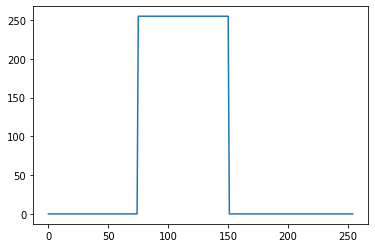

In [11]:
img = sliced_gray(train_imgs[0], 75, 150, 10, method = 0)

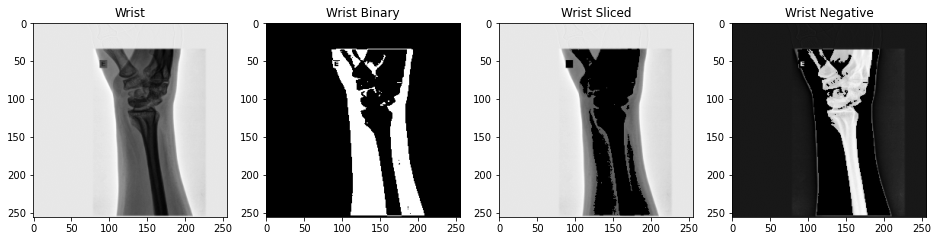

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16,4))

j = 0
img = train_imgs[j]
binary_img = sliced_gray(img, 75, 150, 255, method = 0, plot = False)
slice_img = sliced_gray(img, 0, 90, 0, method = 1, plot = False)
negative_img = sliced_gray(img, 70, 150, 0, method = 2, plot = False)

ax[0].imshow(img, cmap = "gray")
ax[0].set_title(label_names[j])
ax[1].imshow(binary_img, cmap = "gray")
ax[1].set_title(label_names[j] + " Binary")
ax[2].imshow(slice_img, cmap = "gray")
ax[2].set_title(label_names[j] + " Sliced")
ax[3].imshow(negative_img, cmap = "gray")
ax[3].set_title(label_names[j] + " Negative")
plt.show()

### Bag of Features

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from imageio import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from skimage import feature

In [79]:
def get_patches(img_file, random_state = 4, patch_size=(11, 11), n_patches=250):
    '''Extracts subimages
       Parameters
           img_file: path for an image
           patch_size: size of each patch
           n_patches: number of patches to be extracted
    '''

    # img = imread(img_file)
    img = pydicom.dcmread(root+"test_images/"+filename).pixel_array
    img = normalize( img ).astype(np.uint8)
    
    # Extract subimages
    patch = extract_patches_2d(img, 
                               patch_size=patch_size,
                               max_patches=n_patches, 
                               random_state=random_state)
    
    if(len(img.shape) == 3):
      reshaped_patch = patch.reshape((n_patches, np.prod( patch_size ) * img.shape[2] ))
    else:
      reshaped_patch = patch.reshape((n_patches, np.prod( patch_size ) ))
      
    return reshaped_patch

In [82]:
tam_patch = (15, 15)
n_patches = 250
path_imgs = "/content/drive/MyDrive/Colab Notebooks/Processamento de Imagens/train_images/"
random_state = 1

# get list of files
l_imgs = listdir(path_imgs)
# total of images
n_imgs = len(l_imgs)

Patches extracted to create dictionary of features
Total of images =  100
Size of each array of patches =  (250, 225)


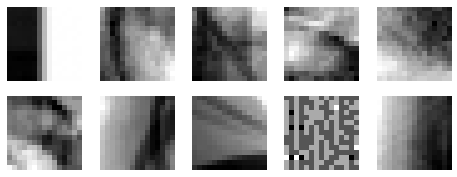

In [90]:
# Extract patches in parallel
# returns a list of the same size of the number of images
patch_arr = Parallel(n_jobs=-1)(delayed(get_patches)(path_imgs+arq_img, 
                                                    random_state,
                                                    tam_patch,
                                                    n_patches)
                                for arq_img in l_imgs[:100])

print('Patches extracted to create dictionary of features')
print('Total of images = ', len(patch_arr))
print('Size of each array of patches = ', patch_arr[0].shape)


img_ind = 32
plt.figure(figsize=(8,3))
for i in np.arange(1,11):
    plt.subplot(2,5,i)
    plt.imshow(patch_arr[img_ind][i].reshape((tam_patch[0],tam_patch[1])), cmap = "gray")
    plt.axis('off')

In [87]:
np.array(patch_arr).shape

(100, 250, 225)

In [ ]:
def lbp_features(img, radius=1, sampling_pixels=8):
    
    # LBP operates in single channel images so if RGB images are provided
    # we have to convert it to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)
    
    # normalize values can also help improving description
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
    
    # compute LBP
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    
    # LBP returns a matrix with the codes, so we compute the histogram
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    # normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns
    return hist